In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')


In [13]:
# Завантаження даних
df = pd.read_csv('Student_Performance.csv')
print(f"Розмір датасету: {df.shape}")
print(df.head())


Розмір датасету: (10000, 6)
   Hours Studied  Previous Scores Extracurricular Activities  Sleep Hours  \
0              7               99                        Yes            9   
1              4               82                         No            4   
2              8               51                        Yes            7   
3              5               52                        Yes            5   
4              7               75                         No            8   

   Sample Question Papers Practiced  Performance Index  
0                                 1               91.0  
1                                 2               65.0  
2                                 2               45.0  
3                                 2               36.0  
4                                 5               66.0  


In [14]:
# Підготовка даних
df_numeric = df.copy()
df_numeric['Extracurricular Activities'] = df_numeric['Extracurricular Activities'].map({'Yes': 1, 'No': 0})
if 'Sample Question Papers Practiced' in df_numeric.columns:
    df_numeric = df_numeric.drop('Sample Question Papers Practiced', axis=1)
print(f"Розмір після обробки: {df_numeric.shape}")


Розмір після обробки: (10000, 5)


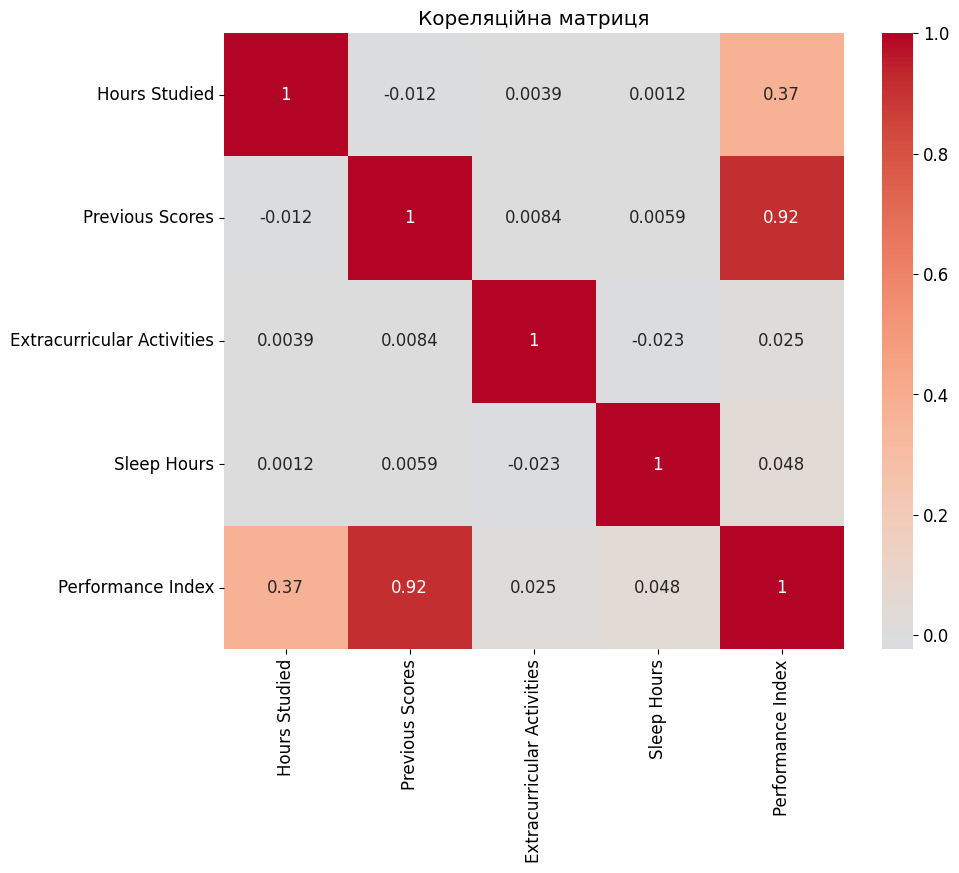

In [15]:
# Кореляційна матриця
plt.figure(figsize=(10, 8))
correlation_matrix = df_numeric.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Кореляційна матриця')
plt.show()


In [16]:
# Підготовка даних для моделі
feature_columns = [col for col in df_numeric.columns if col != 'Performance Index']
X = df_numeric[feature_columns].values #матриця ознак, все що впливає на результат 
y = df_numeric['Performance Index'].values  #цільова змінна яку ми прогнозуємо

# Додавання вільного члена
X_with_intercept = np.column_stack([np.ones(X.shape[0]), X]) #додаємо вільний член до матриці ознак

# Розділення на навчальну та тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(X_with_intercept, y, test_size=0.2, random_state=42) #розділяємо дані на навчальну та тестову вибірки

# Стандартизація ознак
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[:, 1:] = scaler.fit_transform(X_train[:, 1:])
X_test_scaled[:, 1:] = scaler.transform(X_test[:, 1:])

print(f"Навчальна вибірка: {X_train_scaled.shape}, Тестова вибірка: {X_test_scaled.shape}")


Навчальна вибірка: (8000, 5), Тестова вибірка: (2000, 5)


In [ ]:
# Функція градієнтного спуску
def gradient_descent(X, y, theta, learning_rate, epochs): #X - матриця ознак, y - цільова змінна, theta - початкові параметри, learning_rate - швидкість навчання, epochs - кількість епох
    m = len(y) #кількість студентів
    cost_history = [] #список для збереження помилок
    
    for epoch in range(epochs): 
        y_pred = X.dot(theta) #прогноз моделі
        error = y_pred - y #різниця між прогнозом та реальністю
        mse = (1 / (2 * m)) * np.sum(error ** 2)#
        gradient = (1 / m) * X.T.dot(error)
        theta -= learning_rate * gradient
        cost_history.append(mse)
        if epoch % 200 == 0:
            print(f"Епоха {epoch}: MSE = {mse:.6f}")
    
    return theta, cost_history


In [ ]:
# Навчання моделі
learning_rate = 0.01
epochs = 1000
theta_initial = np.zeros(X_train_scaled.shape[1])

print(f"Початкові параметри: {theta_initial}")
print(f"Швидкість навчання: {learning_rate}, Епохи: {epochs}")

theta_final, cost_history = gradient_descent(X_train_scaled, y_train, theta_initial, learning_rate, epochs) 

print(f"\nФінальні параметри (theta): {theta_final}")

# Коефіцієнти моделі
coefficients_df = pd.DataFrame({
    'Ознака': ['Вільний член'] + list(feature_columns),
    'Коефіцієнт': theta_final
})
print(f"\nКоефіцієнти моделі:")
print(coefficients_df)


Початкові параметри: [0. 0. 0. 0. 0.]
Швидкість навчання: 0.01, Епохи: 1000
Епоха 0: MSE = 1714.017500
Епоха 200: MSE = 33.063424
Епоха 400: MSE = 2.790742
Епоха 600: MSE = 2.245438
Епоха 800: MSE = 2.235614

Фінальні параметри (theta): [55.30911213  7.40878974 17.6424331   0.30376319  0.81013374]

Коефіцієнти моделі:
                       Ознака  Коефіцієнт
0                Вільний член   55.309112
1               Hours Studied    7.408790
2             Previous Scores   17.642433
3  Extracurricular Activities    0.303763
4                 Sleep Hours    0.810134


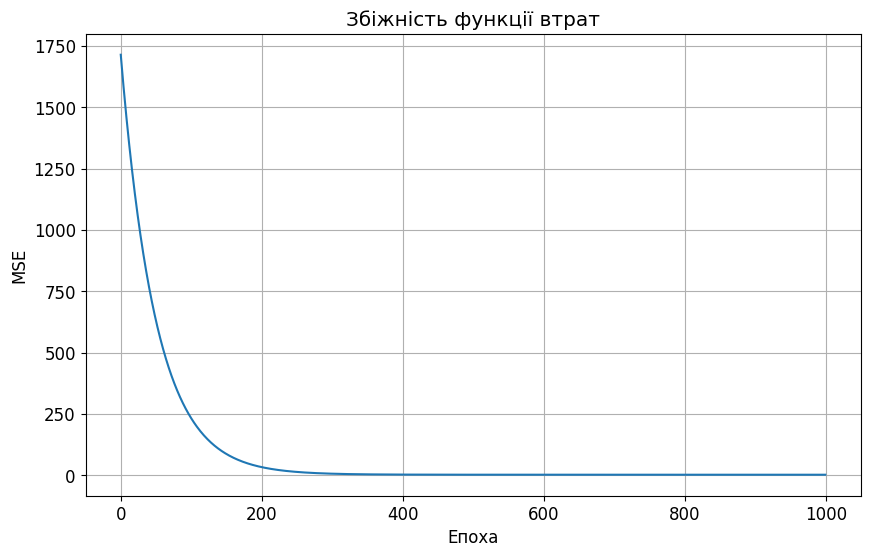

In [19]:
# Графік збіжності функції втрат
plt.figure(figsize=(10, 6))
plt.plot(cost_history)
plt.title('Збіжність функції втрат')
plt.xlabel('Епоха')
plt.ylabel('MSE')
plt.grid(True)
plt.show()


MSE на тестовій вибірці: 4.422112
R² на тестовій вибірці: 0.988067


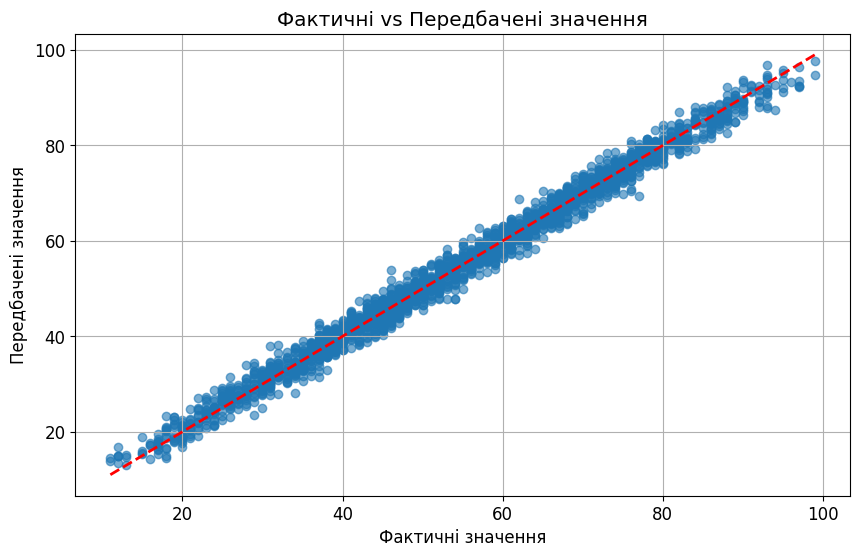

In [20]:
# Оцінка моделі на тестовій вибірці
y_pred = X_test_scaled.dot(theta_final)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE на тестовій вибірці: {mse:.6f}")
print(f"R² на тестовій вибірці: {r2:.6f}")

# Графік фактичних vs передбачених значень
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Фактичні значення')
plt.ylabel('Передбачені значення')
plt.title('Фактичні vs Передбачені значення')
plt.grid(True)
plt.show()


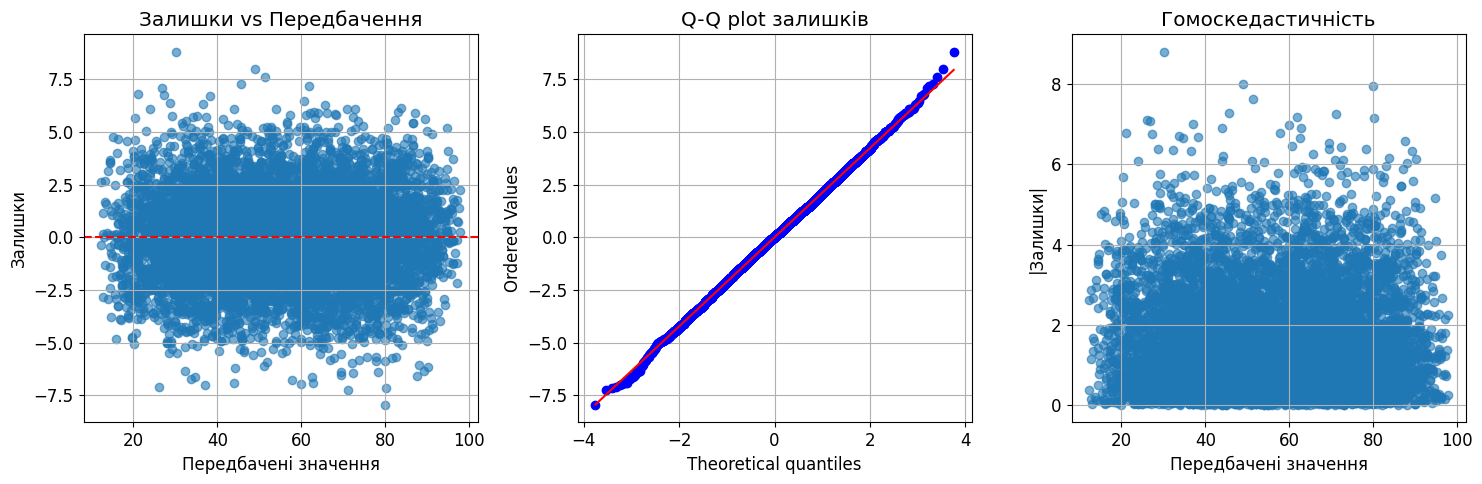

1. Лінійність: Кореляція = 0.0004
2. Нормальність: p-value = 0.4811
3. Гомоскедастичність: Кореляція = -0.0156
4. Автокореляція: Durbin-Watson = 2.0316
5. Викиди: 29 з 8000 спостережень

6. Мультиколінеарність (VIF):
                       Ознака       VIF
0               Hours Studied  1.000182
1             Previous Scores  1.000125
2  Extracurricular Activities  1.000427
3                 Sleep Hours  1.000461

ВИСНОВОК:
Припущення лінійної регресії виконуються:
  - Лінійність - слабка кореляція залишків з передбаченнями
  - Нормальність - p-value > 0.05
  - Гомоскедастичність - слабка кореляція |залишків| з передбаченнями
  - Автокореляція - Durbin-Watson ≈ 2
  - Викиди - незначна кількість в межах норми
  - Мультиколінеарність - VIF < 10 для всіх ознак
Модель показує відмінну якість: R² = 0.988, MSE = 4.422
Модель придатна для прогнозування успішності студентів


In [21]:
# Аналіз припущень лінійної регресії
y_train_pred = X_train_scaled.dot(theta_final)
residuals = y_train - y_train_pred

plt.figure(figsize=(15, 5))

# 1. Лінійність
plt.subplot(1, 3, 1)
plt.scatter(y_train_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Передбачені значення')
plt.ylabel('Залишки')
plt.title('Залишки vs Передбачення')
plt.grid(True)

# 2. Нормальність
plt.subplot(1, 3, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q plot залишків')
plt.grid(True)

# 3. Гомоскедастичність
plt.subplot(1, 3, 3)
plt.scatter(y_train_pred, np.abs(residuals), alpha=0.6)
plt.xlabel('Передбачені значення')
plt.ylabel('|Залишки|')
plt.title('Гомоскедастичність')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"1. Лінійність: Кореляція = {np.corrcoef(y_train_pred, residuals)[0,1]:.4f}")
print(f"2. Нормальність: p-value = {stats.shapiro(residuals)[1]:.4f}")
print(f"3. Гомоскедастичність: Кореляція = {np.corrcoef(y_train_pred, np.abs(residuals))[0,1]:.4f}")
print(f"4. Автокореляція: Durbin-Watson = {durbin_watson(residuals):.4f}")

z_scores = np.abs(stats.zscore(residuals))
outliers = np.sum(z_scores > 3)
print(f"5. Викиди: {outliers} з {len(residuals)} спостережень")

# 6. Мультиколінеарність (VIF)
vif_data = pd.DataFrame()
vif_data["Ознака"] = feature_columns
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled[:, 1:], i) 
                   for i in range(len(feature_columns))]
print(f"\n6. Мультиколінеарність (VIF):")
print(vif_data)

print("\nВИСНОВОК:")
print("Припущення лінійної регресії виконуються:")
print("  - Лінійність - слабка кореляція залишків з передбаченнями")
print("  - Нормальність - p-value > 0.05")
print("  - Гомоскедастичність - слабка кореляція |залишків| з передбаченнями")
print("  - Автокореляція - Durbin-Watson ≈ 2")
print("  - Викиди - незначна кількість в межах норми")
print("  - Мультиколінеарність - VIF < 10 для всіх ознак")
print(f"Модель показує відмінну якість: R² = {r2:.3f}, MSE = {mse:.3f}")
print("Модель придатна для прогнозування успішності студентів")
